The following cell contains secret credentials:

In [1]:
# The code was removed by Watson Studio for sharing.

# Segmenting and Clustering Neighborhoods in Toronto
# Part III

In part I and II we aquired and prepared the data we need to analyse the neighborhoods of Toronto. In this part we enlarge our dataset with the information on venues in range of each neighborhood. Then we will visualize the data to gain insights.

First, let's get our environment ready:

In [2]:
#!conda install -c conda-forge folium --quiet
#!conda install -c conda-forge geocoder --quiet

In [3]:
import folium
import geocoder
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from itertools import combinations
from geopy.distance import distance, great_circle

Now, let's import the dataset from part II:

In [4]:
# Read the csv file we created before; "project.get_file()" is Watson Studio specific
df_toronto = pd.read_csv(project.get_file('toronto_final.csv'))
df_toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Visualize the neighborhoods


In [5]:
# Get the coordinates of Toronto per Mapquest-API
g = geocoder.mapquest('Toronto, Canada', key=MAPQUEST_API_KEY)
    
if g.ok:
    toronto_coordinates = tuple([g.latlng[0], g.latlng[1]])
    print('The geographical coordinates of Toronto are {}, {}.'.format(toronto_coordinates[0], toronto_coordinates[1]))
else:
    print('Something went wrong while getting Toronto\'s coordinates.')

The geographical coordinates of Toronto are 43.651893, -79.381713.


In [6]:
# Create a map of the world centered around Toronto
map_toronto = folium.Map(location=toronto_coordinates, zoom_start=11)

# Add markers of all neighborhoods to the map
for lat, lng, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='lightblue',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)

# display map
map_toronto

## Aquire data on venues

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    '''Get information on venues in range of a given coordinate through Foursquare Developer API'''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        
    return(nearby_venues)

Let's determine a good search radius:

In [8]:
def great_circle_dist(latlon1, latlon2):
    """Uses geopy to calculate distance between coordinates"""
    return great_circle(latlon1, latlon2).meters

def find_nearest(x):
        """Finds nearest neighbor """
        df_distances['distances'] = df_distances.coordinates.apply(great_circle_dist, args=(x,))
        df_distances_sort = df_distances.sort_values(by='distances')
        return (df_distances_sort.values[1][0], df_distances_sort.values[1][2])

coord_list = list(zip(df_toronto['Latitude'], df_toronto['Longitude']))
df_distances = pd.DataFrame({'postcode': df_toronto['Postcode'], 'coordinates': coord_list}, columns=['postcode', 'coordinates'])
    
df_distances['nearest'] = df_distances['coordinates'].apply(find_nearest)
df_distances['distance'] = df_distances.nearest.apply(lambda x: x[1])
del df_distances['nearest']
del df_distances['distances']

display(df_distances.head())
print('The average distance between the all neighborhoods and their nearest neighbor is {0:.2f} meters.'.format(df_distances['distance'].mean()))

,postcode,coordinates,distance
0,M1B,"(43.8066863, -79.19435340000003)",3397.205462
1,M1C,"(43.7845351, -79.16049709999999)",3251.309804
2,M1E,"(43.7635726, -79.1887115)",2411.191341
3,M1G,"(43.7709921, -79.21691740000001)",1827.453921
4,M1H,"(43.773136, -79.23947609999998)",1827.453921


The average distance between the all neighborhoods and their nearest neighbor is 1786.57 meters.


In [9]:
# Create dataframe with venues of each neighborhood
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                 latitudes=df_toronto['Latitude'],
                                 longitudes=df_toronto['Longitude'],
                                 radius=890
                                )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

## Examine the data on venues

In [10]:
print("The size of the venues dataframe: {}".format(toronto_venues.shape))
toronto_venues.head()

The size of the venues dataframe: (4288, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,"Rouge, Malvern",43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store
2,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
3,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
4,"Rouge, Malvern",43.806686,-79.194353,Harvey's,43.800106,-79.198258,Fast Food Restaurant


In [11]:
print('Count of venues per neighborhood:')
display(pd.DataFrame(toronto_venues.groupby('Neighborhood')['Venue'].count()))

Count of venues per neighborhood:


,Venue
Neighborhood,
"Adelaide, King, Richmond",100
Agincourt,39
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",25
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",16
"Alderwood, Long Branch",14
"Bathurst Manor, Downsview North, Wilson Heights",26
Bayview Village,13
"Bedford Park, Lawrence Manor East",44
Berczy Park,100


In [12]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 329 unique categories.


In [13]:
# One hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Rename column
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# Group by Neighborhood and calculate mean occurence of each Venue Category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

### Most common venues per neighborhood

In [14]:
def return_most_common_venues(row, num_top_venues):
    '''Return the most common venues of a given column of a dataframe'''
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))
        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for idx in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[idx, 1:] = return_most_common_venues(toronto_grouped.iloc[idx, :], num_top_venues)
    
neighborhoods_venues_sorted.head(12)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Hotel,American Restaurant,Gastropub
1,Agincourt,Chinese Restaurant,Shopping Mall,Bakery,Supermarket,Shanghai Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Park,Pizza Place,Korean Restaurant,Bakery
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Fast Food Restaurant,Pharmacy,Liquor Store
4,"Alderwood, Long Branch",Discount Store,Pizza Place,Gas Station,Pharmacy,Skating Rink
5,"Bathurst Manor, Downsview North, Wilson Heights",Pizza Place,Coffee Shop,Pharmacy,Middle Eastern Restaurant,Frozen Yogurt Shop
6,Bayview Village,Bank,Japanese Restaurant,Fast Food Restaurant,Grocery Store,Intersection
7,"Bedford Park, Lawrence Manor East",Italian Restaurant,Fast Food Restaurant,Coffee Shop,Sushi Restaurant,Comfort Food Restaurant
8,Berczy Park,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
9,"Birch Cliff, Cliffside West",Park,College Stadium,Gym,Discount Store,Café


## Cluster the Neighborhoods

### Find optimal number of clusters for K-Means Model

In [16]:
# Determine optimal value of k (quantity of clusters)
from sklearn.metrics import silhouette_score

sum_of_squared_distances = []
sil_coeff = []

X = toronto_grouped.drop('Neighborhood', 1)
K = range(2,21)

for k in K:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    sil_coeff.append(silhouette_score(X, km.labels_, metric='euclidean'))
    sum_of_squared_distances.append(km.inertia_)

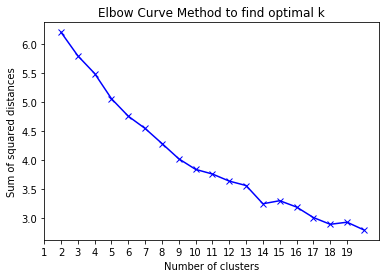

In [17]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(1, len(K)+1, 1.0))
plt.ylabel('Sum of squared distances')
plt.title('Elbow Curve Method to find optimal k')
plt.show()

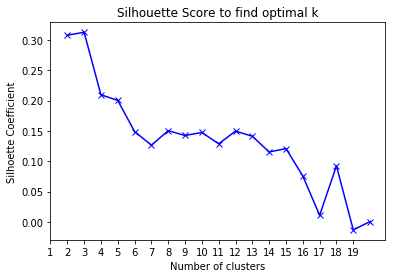

In [18]:
plt.plot(K, sil_coeff, 'bx-')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(1, len(K)+1, 1.0))
plt.ylabel('Silhoette Coefficient')
plt.title('Silhouette Score to find optimal k')
plt.show()

### Build and train Clustering Model

In [19]:
kclusters = 10
kmeans_model = KMeans(n_clusters=kclusters, random_state=1)
kmeans_model.fit(toronto_grouped.drop('Neighborhood', 1))
kmeans_model.labels_

array([2, 2, 2, 4, 4, 2, 5, 2, 2, 5, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,
       9, 4, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 4, 5, 9, 4, 2, 9, 2, 2, 2,
       2, 4, 4, 2, 2, 2, 2, 6, 5, 2, 3, 5, 4, 5, 4, 2, 4, 2, 2, 2, 2, 2, 5,
       2, 2, 7, 2, 2, 5, 5, 0, 4, 2, 2, 4, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2,
       5, 4, 4, 2, 4, 7, 4, 4, 5], dtype=int32)

### Visualize Clusters

In [20]:
# Merge datasets
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_model.labels_)
toronto_merged = df_toronto.rename(columns={'Neighbourhood': 'Neighborhood'})
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='right').reset_index(drop=True)

# How does our combined dataframe look like? 
toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,4,Fast Food Restaurant,Coffee Shop,Spa,Construction & Landscaping,Fruit & Vegetable Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,6,Burger Joint,Breakfast Spot,Playground,Italian Restaurant,Ethiopian Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4,Pizza Place,Fast Food Restaurant,Coffee Shop,Smoothie Shop,Bank
3,M1G,Scarborough,Woburn,43.770992,-79.216917,7,Coffee Shop,Dog Run,Park,Zoo,Empanada Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Bakery,Indian Restaurant,Coffee Shop,Asian Restaurant,Athletics & Sports


In [21]:
# create map
map_clusters = folium.Map(location=toronto_coordinates, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.viridis(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'],
                                  toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

### Examine Clusters

In [22]:
# How many neighborhoods per Cluster?
toronto_merged['Cluster Labels'].value_counts()

2    58
4    19
5    14
9     3
7     2
8     1
6     1
3     1
1     1
0     1
Name: Cluster Labels, dtype: int64

In [23]:
for i in range(kclusters):
    print('Cluster No. {}'.format(i))
    display(toronto_merged.loc[toronto_merged['Cluster Labels'] == i])
    print('-------------------------------------')

Cluster No. 0


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
62,M5N,Central Toronto,Roselawn,43.711695,-79.416936,0,Garden,Playground,Skating Rink,Music Venue,Pet Store


-------------------------------------
Cluster No. 1


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
19,M2L,North York,"Silver Hills, York Mills",43.75749,-79.374714,1,Pool,Middle Eastern Restaurant,Zoo,Empanada Restaurant,Dive Bar


-------------------------------------
Cluster No. 2


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Bakery,Indian Restaurant,Coffee Shop,Asian Restaurant,Athletics & Sports
10,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,2,Furniture / Home Store,Coffee Shop,Chinese Restaurant,Indian Restaurant,Pizza Place
11,M1R,Scarborough,"Maryvale, Wexford",43.750071,-79.295849,2,Pizza Place,Burger Joint,Restaurant,Middle Eastern Restaurant,Fish Market
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,2,Chinese Restaurant,Shopping Mall,Bakery,Supermarket,Shanghai Restaurant
14,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,2,Chinese Restaurant,Park,Pizza Place,Korean Restaurant,Bakery
17,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,2,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Food Court
20,M2M,North York,"Newtonbrook, Willowdale",43.789053,-79.408493,2,Korean Restaurant,Pizza Place,Middle Eastern Restaurant,Café,Coffee Shop
21,M2N,North York,Willowdale South,43.770120,-79.408493,2,Coffee Shop,Ramen Restaurant,Japanese Restaurant,Pizza Place,Bubble Tea Shop
25,M3B,North York,Don Mills North,43.745906,-79.352188,2,Japanese Restaurant,Paper / Office Supplies Store,Supermarket,Caribbean Restaurant,Baseball Field
26,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923,2,Gym,Coffee Shop,Japanese Restaurant,Beer Store,Asian Restaurant


-------------------------------------
Cluster No. 3


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
89,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509,3,Park,Gym / Fitness Center,Shopping Mall,Dim Sum Restaurant,Discount Store


-------------------------------------
Cluster No. 4


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,4,Fast Food Restaurant,Coffee Shop,Spa,Construction & Landscaping,Fruit & Vegetable Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4,Pizza Place,Fast Food Restaurant,Coffee Shop,Smoothie Shop,Bank
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,4,Fast Food Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Restaurant
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,4,Coffee Shop,Chinese Restaurant,Grocery Store,Discount Store,Pizza Place
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,4,Fast Food Restaurant,Pizza Place,Burger Joint,Furniture / Home Store,Park
13,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,4,Pizza Place,Shopping Mall,Bus Stop,Golf Course,Noodle House
15,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,4,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Sandwich Place,Indian Restaurant
23,M2R,North York,Willowdale West,43.782736,-79.442259,4,Butcher,Coffee Shop,Pizza Place,Convenience Store,Pharmacy
32,M3N,North York,Downsview Northwest,43.761631,-79.520999,4,Hotel,Pizza Place,Fast Food Restaurant,Pharmacy,Grocery Store
34,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937,4,Pizza Place,Brewery,Fast Food Restaurant,Breakfast Spot,Rock Climbing Spot


-------------------------------------
Cluster No. 5


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,5,Park,College Stadium,Gym,Discount Store,Café
16,M2H,North York,Hillcrest Village,43.803762,-79.363452,5,Pharmacy,Park,Pizza Place,Housing Development,Bank
18,M2K,North York,Bayview Village,43.786947,-79.385975,5,Bank,Japanese Restaurant,Fast Food Restaurant,Grocery Store,Intersection
22,M2P,North York,York Mills West,43.752758,-79.400049,5,Gym,Park,Golf Course,Bank,Dog Run
24,M3A,North York,Parkwoods,43.753259,-79.329656,5,Park,Bus Stop,Grocery Store,Café,Discount Store
30,M3L,North York,Downsview West,43.739015,-79.506944,5,Park,Grocery Store,Spa,Coffee Shop,Pizza Place
33,M4A,North York,Victoria Village,43.725882,-79.315572,5,Park,Hockey Arena,Pizza Place,Sporting Goods Shop,Intersection
47,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,5,Grocery Store,Park,Playground,Café,Bank
49,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,5,Park,Coffee Shop,Bank,Grocery Store,Candy Store
73,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,5,Park,Pharmacy,Coffee Shop,Discount Store,Bank


-------------------------------------
Cluster No. 6


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,6,Burger Joint,Breakfast Spot,Playground,Italian Restaurant,Ethiopian Restaurant


-------------------------------------
Cluster No. 7


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,M1G,Scarborough,Woburn,43.770992,-79.216917,7,Coffee Shop,Dog Run,Park,Zoo,Empanada Restaurant
100,M9W,Etobicoke,Northwest,43.706748,-79.594054,7,Dog Run,Coffee Shop,Hotel,Zoo,Empanada Restaurant


-------------------------------------
Cluster No. 8


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
31,M3M,North York,Downsview Central,43.728496,-79.495697,8,Food Truck,Vietnamese Restaurant,Restaurant,Baseball Field,Zoo


-------------------------------------
Cluster No. 9


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,9,Intersection,Diner,Bus Line,Coffee Shop,Bakery
78,M6L,North York,"Downsview, North Park, Upwood Park",43.713756,-79.490074,9,Bakery,Coffee Shop,Park,Convenience Store,Zoo
95,M9M,North York,"Emery, Humberlea",43.724766,-79.532242,9,Bakery,Golf Course,Convenience Store,Intersection,Park


-------------------------------------
